In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from WindPy import w
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

## 国债数据最早从08年开始

In [2]:
def stock_data(stockList, factor, startDate, endDate):
    data = w.wsd(stockList, factor, startDate, endDate, "")
    df = pd.DataFrame(data.Data, columns = data.Times, index = stockList).T
    return df

In [3]:
def weight_stock(m, ratio, weights):
    N_sect = 10
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
    return np.around(weights[index],decimals =2)

In [4]:
def updateMoney(t,t_lasttime,weights,money,stockClose):
    dailyReturnOfBond = 0.04/365
    bondIncome = (t-t_lasttime).days * dailyReturnOfBond * (1-weights) * money
    stockIncome = (stockClose[t]-stockClose[t_lasttime])/stockClose[t_lasttime] * weights * money
    money += (stockIncome + bondIncome)
    return money

#### 09年开始投资，以截至2020年底的总股债比数据（不变动）的策略

In [5]:
def return_strategy(returnRatio,stockClosedf):
    for stock in returnRatio:
        m = returnRatio[stock]
        stockClose = stockClosedf[stock]
        weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]

        weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
        t = t_lasttime = m.index[0]
        money = 1

        for i in range(1,len(m)):     
            weights_new = weight_stock(m,m[i],weights_assigned)
            if i%21 == 0:
    #         if weights_new != weights_lasttime:
                t = m.index[i]
                money = updateMoney(t,t_lasttime, weights_lasttime,money,stockClose)
                weights_lasttime = weights_new
                t_lasttime = t
        print(stock)
        print("开始日期("+str(stockClose.index[0])+")："+str(stockClose[0]) +"    结束日期("+str(stockClose.index[-1])+")："+str(stockClose[-1]))
        print("指数总收益率： " + str(stockClose[-1]/stockClose[0] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[0])**(1/12) - 1))
        print("策略总收益率： " + str(money - 1) + "   指数年化收益率： " + str(money**(1/12) - 1))
        print()
    return[str(stockClose.index[-1]),money,stockClose[-1]/stockClose[0]]

In [6]:
def strategy_startdate(startDate):
    stockList = ["000300.SH"]
#     startDate = "20080101"
    endDate = "20210101"
    N = 1 # N-month return of index
    
    stockPEdf = stock_data(stockList, "pe_ttm", startDate, endDate)
    bond10y = w.edb("M1001654", startDate, endDate)
    bonddf = pd.DataFrame(bond10y.Data,columns = bond10y.Times, index = ["bond10y"]).T/100
    merged_data = pd.concat([1/stockPEdf,bonddf],axis = 1,join = 'inner')
    
    returnRatio = pd.DataFrame(index = stockList,columns = merged_data.index).T
    for i in stockList:
        returnRatio[i] = merged_data[i].T / merged_data[merged_data.columns[-1]].T
    returnRatio = np.around(returnRatio, decimals = 2, out = None)
    
    stockClosedf = stock_data(stockList, 'CLOSE', startDate, endDate)
    
    return_strategy(returnRatio,stockClosedf)

In [7]:
strategy_startdate("20090101") 

000300.SH
开始日期(2009-01-05)：1882.959    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.7676059330022582   指数年化收益率： 0.08853405625683264
策略总收益率： 2.2393156722600347   指数年化收益率： 0.10290415456510504



In [8]:
stockList = ["000300.SH"]
startDate = "20090101"
endDate = "20210101"
N = 1 # N-month return of index

stockPEdf = stock_data(stockList, "pe_ttm", startDate, endDate)
bond10y = w.edb("M1001654", startDate, endDate)
bonddf = pd.DataFrame(bond10y.Data,columns = bond10y.Times, index = ["bond10y"]).T/100
merged_data = pd.concat([1/stockPEdf,bonddf],axis = 1,join = 'inner')

returnRatio = pd.DataFrame(index = stockList,columns = merged_data.index).T
for i in stockList:
    returnRatio[i] = merged_data[i].T / merged_data[merged_data.columns[-1]].T
returnRatio = np.around(returnRatio, decimals = 2, out = None)

stockClosedf = stock_data(stockList, 'CLOSE', startDate, endDate)

In [9]:
def return_strategy_test(testStartDate,returnRatio,stockClosedf):
    for stock in returnRatio:
        m = returnRatio[stock]
        stockClose = stockClosedf[stock]
        weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]

        t = t_lasttime = testStartDate
        weights_new = weights_lasttime = weight_stock(m[:t],m[t],weights_assigned)
        money = 1

        time_all = []
        money_all = []
        index_all = []
        time_all.append(t)
        money_all.append(money)
        index_all.append(stockClose[t])
        
        testStart_indexNum = m.index.tolist().index(testStartDate)
        for i in range(testStart_indexNum+1,len(m)):   
            weights_new = weight_stock(m[:(i+1)],m[i],weights_assigned)
            if i%21 == 0:
    #         if weights_new != weights_lasttime:
                t = m.index[i]
                money = updateMoney(t,t_lasttime, weights_lasttime,money,stockClose)
                weights_lasttime = weights_new
                t_lasttime = t
                
                time_all.append(t)
                money_all.append(money)
                index_all.append(stockClose[t])
                
        startYear = str(testStartDate).split("-")[0]
        if startYear == '2014':
            denominator = 7
        elif startYear == '2015':
            denominator = 6
        elif startYear == '2016':
            denominator = 5
        elif startYear == '2017':
            denominator = 4
        print(stock)
        print("训练开始日期("+str(stockClose.index[0])+")："+str(stockClose[0]) + "   测试开始日期("+str(testStartDate)+")："+str(stockClose[testStart_indexNum+1]) +"    结束日期("+str(stockClose.index[-1])+")："+str(stockClose[-1]))
        print("指数总收益率： " + str(stockClose[-1]/stockClose[testStart_indexNum+1] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[testStart_indexNum+1])**(1/denominator) - 1))
        print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/denominator) - 1))
        print()
        return[time_all,money_all,index_all]

## 14年初投入资金

In [10]:
testStartDate  = datetime.date.fromisoformat('2014-01-02')
[time_all,money_all,index_all] = return_strategy_test(testStartDate,returnRatio,stockClosedf)

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2014-01-02)：2321.978    结束日期(2020-12-31)：5211.2885
指数总收益率： 1.2443315569742692   指数年化收益率： 0.12241971926055517
策略总收益率： 1.5789193328511368   策略年化收益率： 0.1449244306792794



## 投入资金变化情况

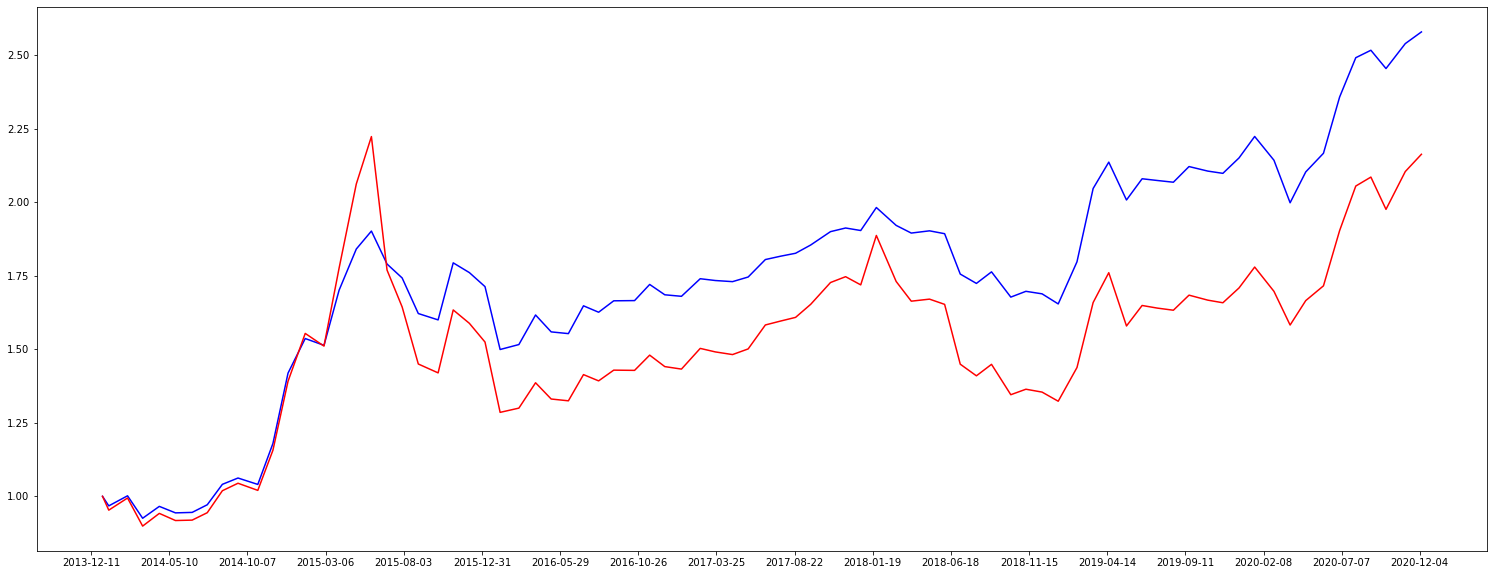

In [11]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,(money_all),color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(150))
# ax1.grid()
# ax2 = ax1.twinx() 
ax1.plot(time_all,(index_all/index_all[0]),color = 'red')

## 收益率变化情况

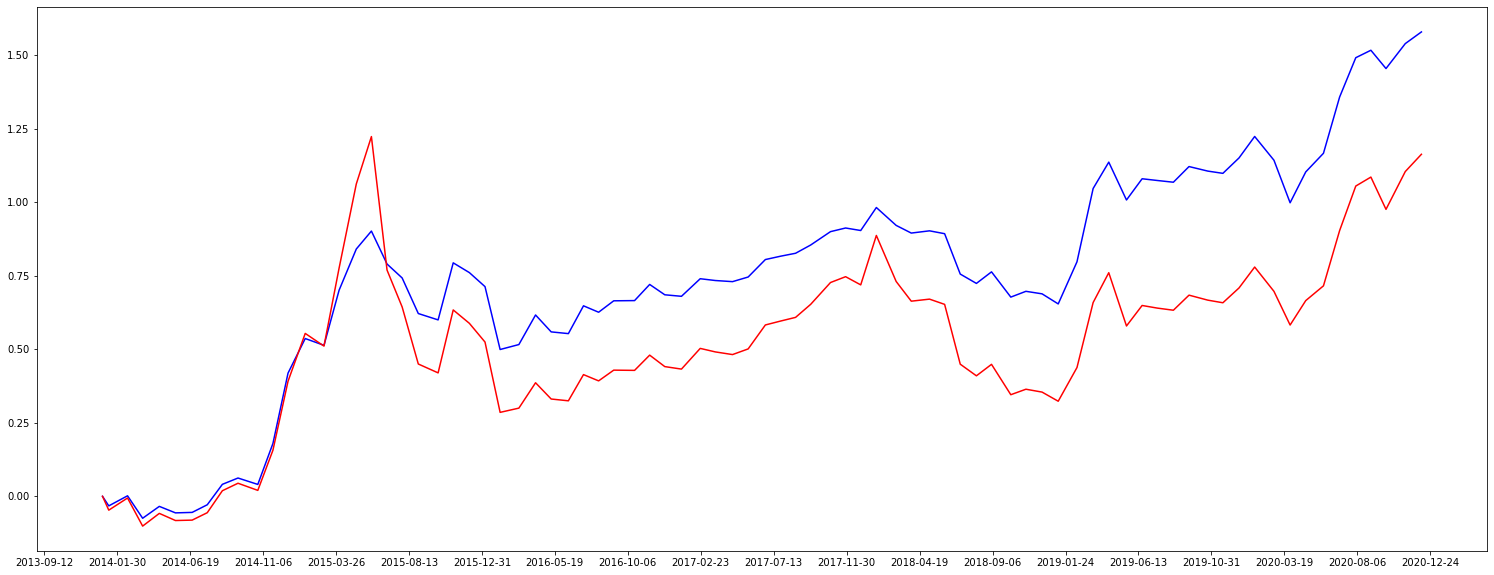

In [12]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,[i-1 for i in money_all],color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(140))
# ax1.grid()
# ax2 = ax1.twinx() 
ax1.plot(time_all,[i-1 for i in index_all/index_all[0]],color = 'red')

### 策略最大回撤

In [13]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(money_all)):
    for j in range(i+1,len(money_all)):
        if (money_all[i]-money_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = money_all[i]-money_all[j]
print("策略最大回撤："+str(max_drawdown/money_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(money_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end])+ "("+str(np.around(money_all[max_drawdown_end],decimals =3))+")")

策略最大回撤：0.21173071363294851   时间：2015-06-02(1.902) 至 2016-02-04(1.499)


### 指数最大回撤

In [14]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(index_all)):
    for j in range(i+1,len(index_all)):
        if (index_all[i]-index_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = index_all[i]-index_all[j]

print("指数最大回撤："+str(max_drawdown/index_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(index_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end]) + "("+str(np.around(index_all[max_drawdown_end],decimals =3))+")")

指数最大回撤：0.42176773146166024   时间：2015-06-02(5161.87) 至 2016-02-04(2984.76)


## 15年初投入资金

In [15]:
testStartDate  = datetime.date.fromisoformat('2015-01-05')
[time_all,money_all,index_all] = return_strategy_test(testStartDate,returnRatio,stockClosedf)

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2015-01-05)：3641.541    结束日期(2020-12-31)：5211.2885
指数总收益率： 0.43106682033787336   指数年化收益率： 0.06155700078482851
策略总收益率： 0.672652184621632   策略年化收益率： 0.08951765889809282



## 投入资金变化情况

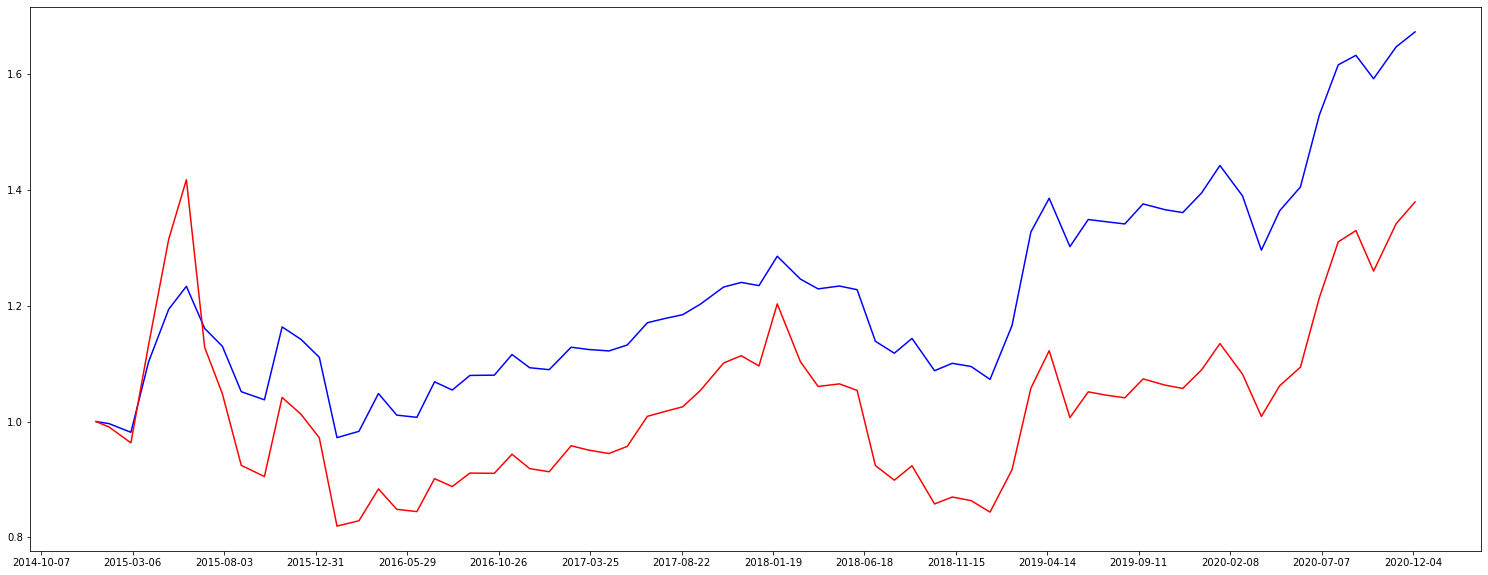

In [16]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,(money_all),color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(150))
# ax1.grid()
# ax2 = ax1.twinx() 
ax1.plot(time_all,(index_all/index_all[0]),color = 'red')

## 收益率变化情况

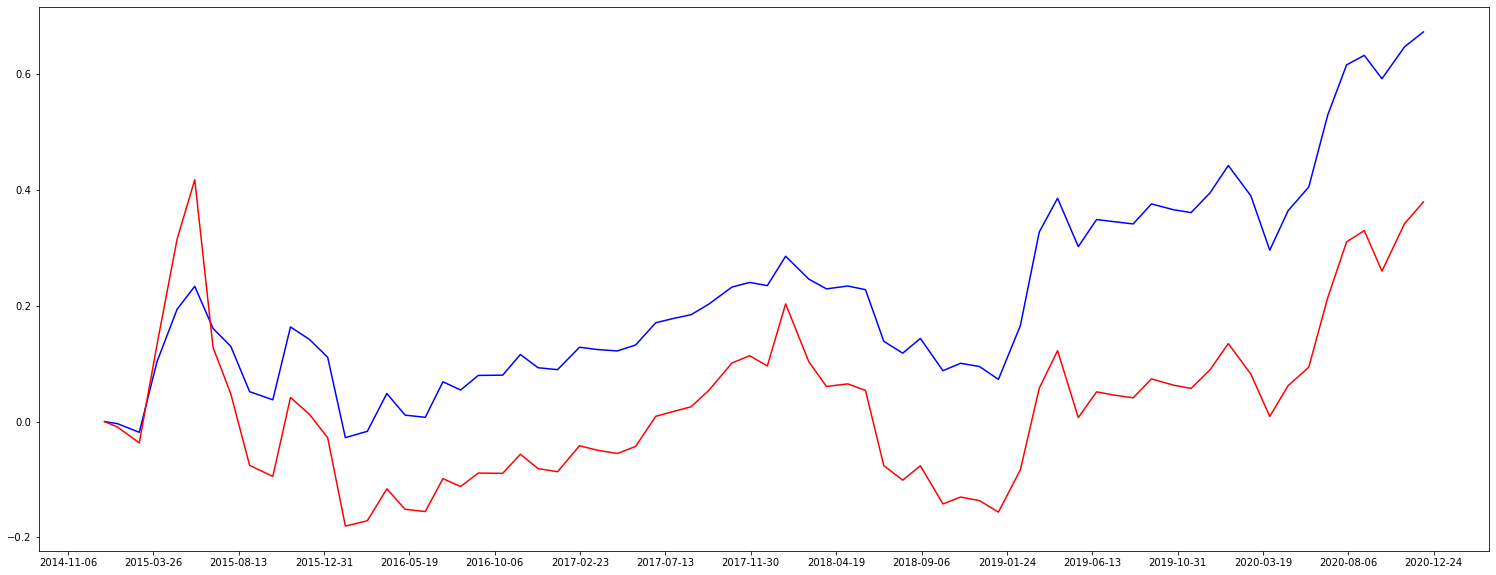

In [17]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,[i-1 for i in money_all],color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(140))
# ax1.grid()
# ax2 = ax1.twinx() 
ax1.plot(time_all,[i-1 for i in index_all/index_all[0]],color = 'red')

### 策略最大回撤

In [18]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(money_all)):
    for j in range(i+1,len(money_all)):
        if (money_all[i]-money_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = money_all[i]-money_all[j]
print("策略最大回撤："+str(max_drawdown/money_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(money_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end])+ "("+str(np.around(money_all[max_drawdown_end],decimals =3))+")")

策略最大回撤：0.21173071363294854   时间：2015-06-02(1.233) 至 2016-02-04(0.972)


### 指数最大回撤

In [19]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(index_all)):
    for j in range(i+1,len(index_all)):
        if (index_all[i]-index_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = index_all[i]-index_all[j]

print("指数最大回撤："+str(max_drawdown/index_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(index_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end]) + "("+str(np.around(index_all[max_drawdown_end],decimals =3))+")")

指数最大回撤：0.42176773146166024   时间：2015-06-02(5161.87) 至 2016-02-04(2984.76)


## 16年初投入资金

In [20]:
testStartDate  = datetime.date.fromisoformat('2016-01-04')
[time_all,money_all,index_all] = return_strategy_test(testStartDate,returnRatio,stockClosedf)

000300.SH
训练开始日期(2009-01-05)：1882.959   测试开始日期(2016-01-04)：3469.0662    结束日期(2020-12-31)：5211.2885
指数总收益率： 0.5022165042569666   指数年化收益率： 0.08479208010231831
策略总收益率： 0.5332268794398414   策略年化收益率： 0.08923423994909863



## 投入资金变化情况

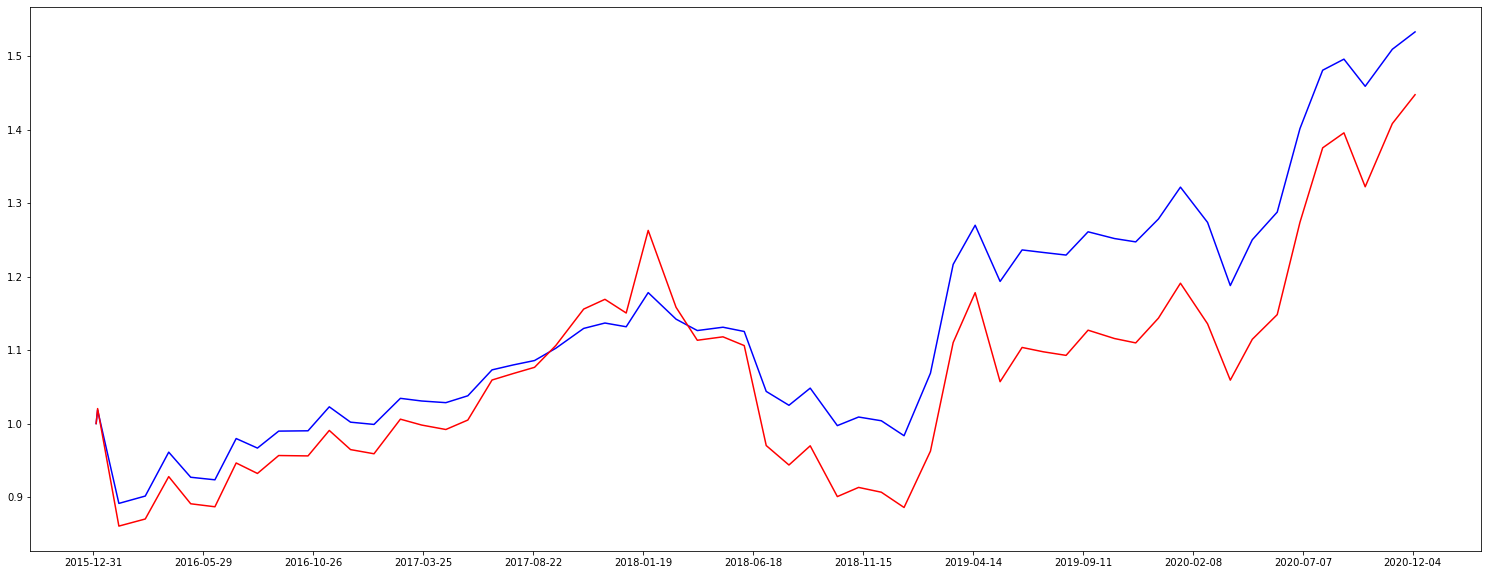

In [21]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,(money_all),color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(150))
# ax1.grid()
# ax2 = ax1.twinx() 
ax1.plot(time_all,(index_all/index_all[0]),color = 'red')

## 收益率变化情况

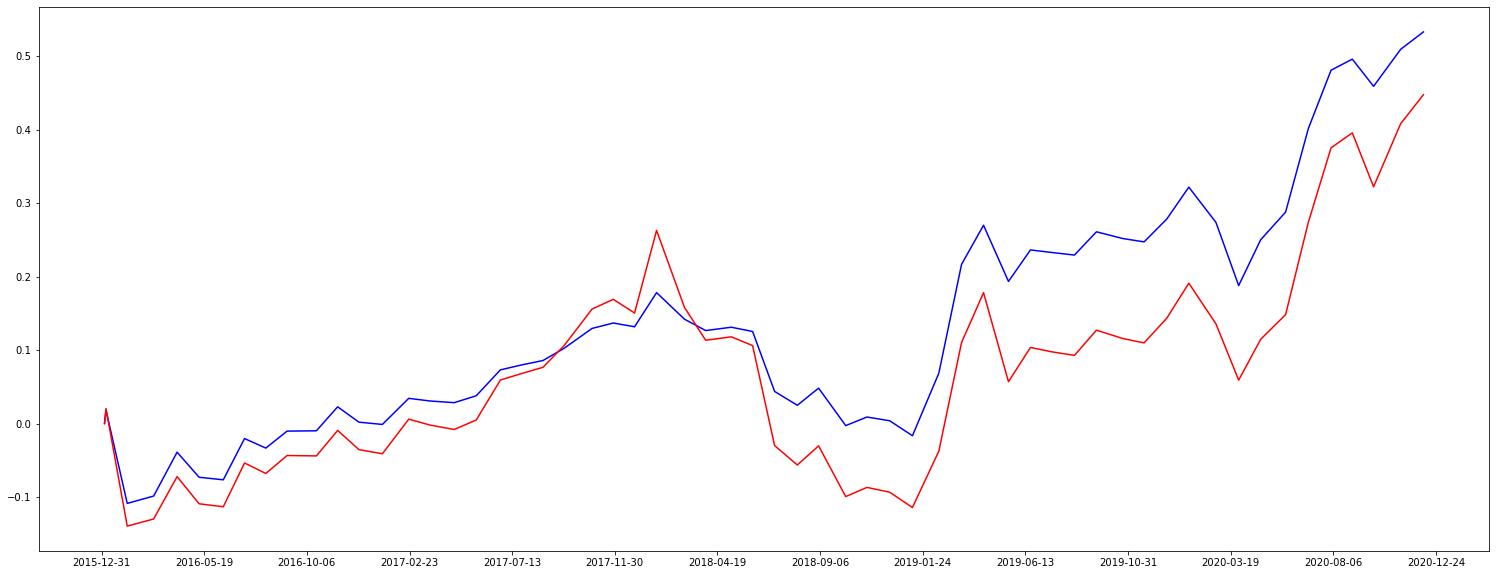

In [22]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,[i-1 for i in money_all],color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(140))
# ax1.grid()
# ax2 = ax1.twinx() 
ax1.plot(time_all,[i-1 for i in index_all/index_all[0]],color = 'red')

### 策略最大回撤

In [23]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(money_all)):
    for j in range(i+1,len(money_all)):
        if (money_all[i]-money_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = money_all[i]-money_all[j]
print("策略最大回撤："+str(max_drawdown/money_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(money_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end])+ "("+str(np.around(money_all[max_drawdown_end],decimals =3))+")")

策略最大回撤：0.16536176482409837   时间：2018-01-26(1.178) 至 2019-01-10(0.983)


### 指数最大回撤

In [24]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(index_all)):
    for j in range(i+1,len(index_all)):
        if (index_all[i]-index_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = index_all[i]-index_all[j]

print("指数最大回撤："+str(max_drawdown/index_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(index_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end]) + "("+str(np.around(index_all[max_drawdown_end],decimals =3))+")")

指数最大回撤：0.29868151449857483   时间：2018-01-26(4381.3) 至 2019-01-10(3072.686)


### 股债收益比

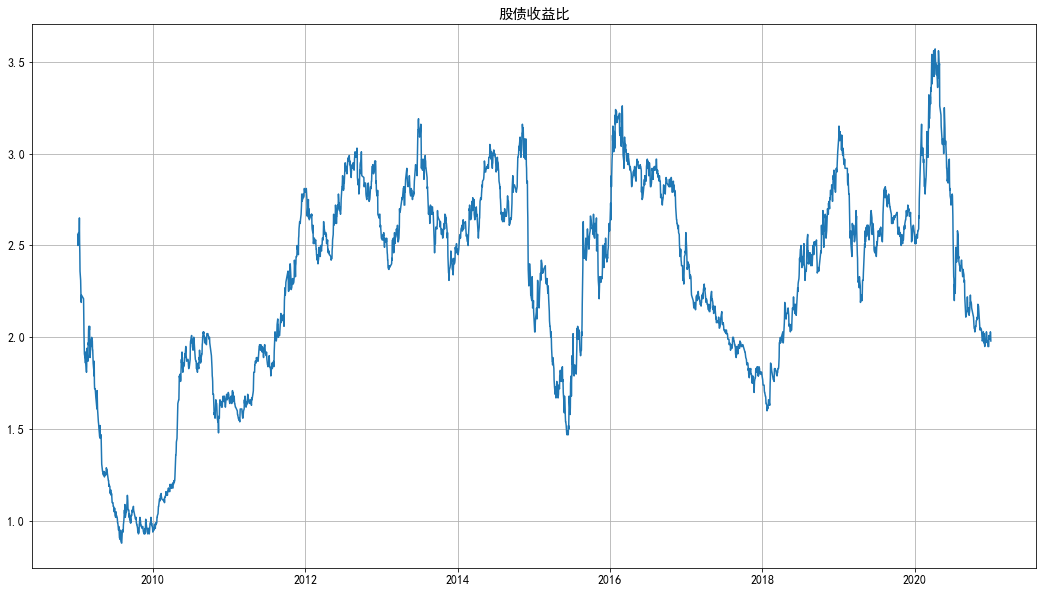

In [25]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rc('font', size=12)
plt.figure(figsize=(18,10))
plt.plot(returnRatio)
plt.title("股债收益比")
plt.grid()

### 股债比频率分布直方图

C:\ProgramData\Anaconda3\Lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='000300.SH', ylabel='Density'>

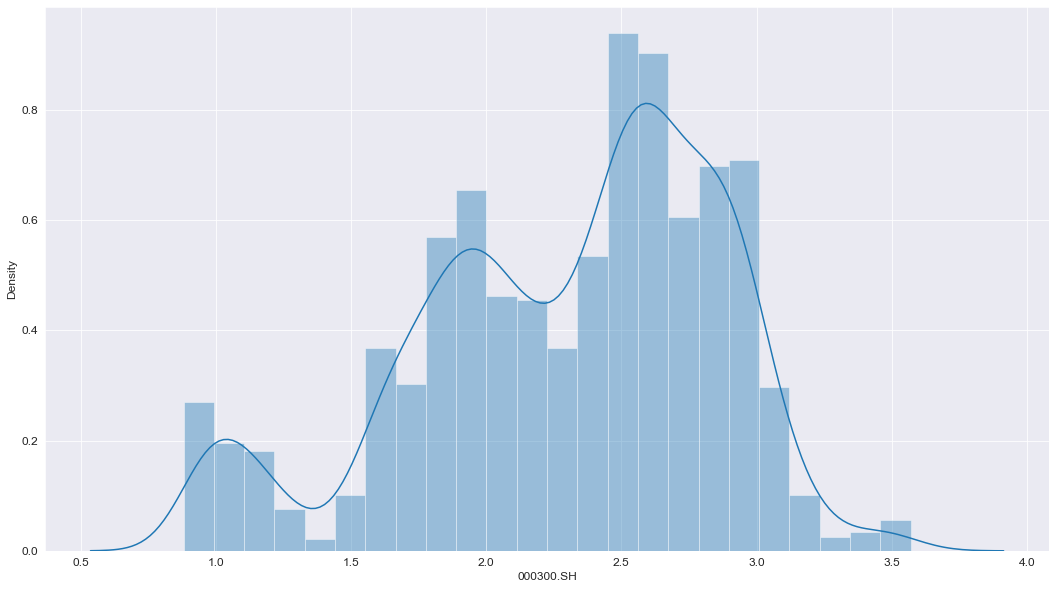

In [26]:
import seaborn as sns
plt.figure(figsize=(18, 10))
sns.set_style('darkgrid')
sns.distplot(returnRatio['000300.SH'])

#### 存在问题：大轮廓：左偏态分布Left Skewed (负偏态Negative skewness)    V.S.   小轮廓多个峰值
#### 不应该直接用标准差去求（标准分布），但可通过对数变换，平方根变换，倒数变换，平方根反转旋变换将偏态分布转换为正态分布